In [ ]:
#hide
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#hide
%cd drive/My\ Drive/repositories/covid19_synthesis/

/content/drive/My Drive/repositories/covid19_synthesis


In [ ]:
#hide
from nbdev_c19_synthesis.c19_synthesis.core import *

In [ ]:
#hide
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import label
from scipy.ndimage import binary_erosion, binary_dilation
from scipy import ndimage

In [ ]:
#hide
from sklearn.cluster import DBSCAN
from copy import copy
from scipy.ndimage import binary_closing
from scipy.ndimage import distance_transform_bf

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

# Project name here

> Summary description here.

This file will become your README and also the index of your documentation.

## Install

`pip install your_project_name`

## How to use

Fill me in please! Don't forget code examples:

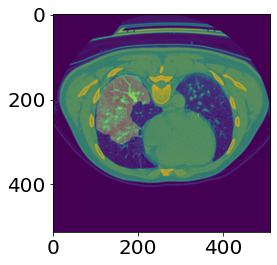

In [ ]:
# read files
filename = 'covid19-A-0003_ct.nii.gz'
path_source = '/content/drive/My Drive/Datasets/covid19/COVID-19-20_v2/'
path_dest = '/content/drive/My Drive/KCL/covid19/inpainting_results/'

ct, ct_mask, ct_seg = read_covid_CT_and_mask(path_source, filename)
ct, ct_mask, ct_seg = normalize_rotate(ct, ct_mask, ct_seg)
plt.imshow(ct[...,100])
plt.imshow(ct_mask[...,100], alpha=.3);

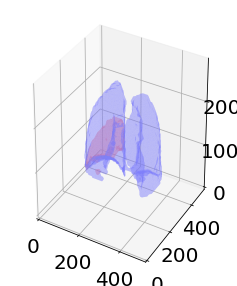

In [ ]:
#@title plot ct {vertical-output: true}
ct_small, ct_mask_small, ct_seg_small = ct, ct_mask, ct_seg
labelled, nr = label(ct_seg_small>0)
largest_component = (labelled == (np.bincount(labelled.flat)[1:].argmax() + 1))
a=np.moveaxis(largest_component,2,0)
b=np.moveaxis(ct_mask_small,2,0)
plot_3d_2(a, b, .5, detail_speed=8, detail_speed2=8, figsize=(4,5))

118
2


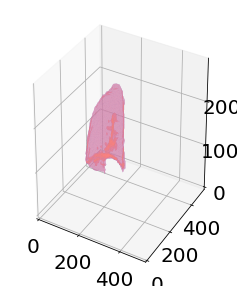

In [ ]:
#@title erode masks to separate the two lungs and get indiviual masks {vertical-output: true}
ERODE_ITER = 5
ct_seg_erod = binary_erosion(ct_seg_small>0, iterations=ERODE_ITER)
lab, nr = label(ct_seg_erod)
print(nr)
lab_areas = np.array(ndimage.sum(ct_seg_erod, lab, np.arange(lab.max()+1)))
mask_small_lab_areas = lab_areas > 500000
two_lungs = mask_small_lab_areas[lab.ravel()].reshape(lab.shape)
two_lungs, nr = label(two_lungs)
assert nr == 2
print(nr)
plot_3d_2(np.moveaxis(two_lungs==2,2,0), np.moveaxis(two_lungs==2,2,0), .5, detail_speed=8, detail_speed2=8, figsize=(4,5))

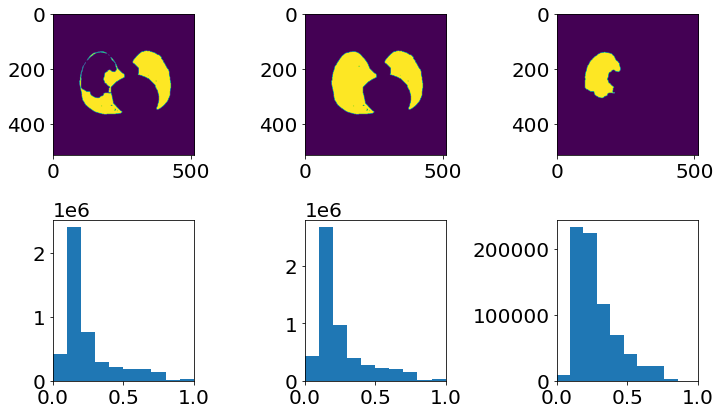

In [ ]:
#@title get masks {vertical-output: true}
bkgd = ct_seg_small == 0
target_mask = np.logical_or(bkgd,ct_mask_small)
target_mask = ~target_mask
target_mask2 = ~bkgd
target_mask3 = ct_mask_small.astype(bool)
# ========
SLICE=100
fig, ax = plt.subplots(2,3,figsize=(10,6))
ax[0,0].imshow(target_mask[...,SLICE])
ax[1,0].hist(ct_small[np.where(target_mask!=0)].flatten()); ax[1,0].set_xlim([0,1]);
ax[0,1].imshow(target_mask2[...,SLICE])
ax[1,1].hist(ct_small[np.where(target_mask2!=0)].flatten()); ax[1,1].set_xlim([0,1]);
ax[0,2].imshow(target_mask3[...,SLICE])
ax[1,2].hist(ct_small[np.where(target_mask3!=0)].flatten()); ax[1,2].set_xlim([0,1]);
plt.tight_layout()

26 141 364 97 241 64 165


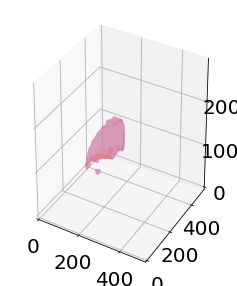

In [ ]:
#@title label {vertical-output: true}
lab, nr_ = label(target_mask3)
y_max, y_min, x_max, x_min, z_max, z_min = get_min_max(target_mask3)
print(nr_, y_max, y_min, x_max, x_min, z_max, z_min)
plot_3d_2(np.moveaxis(target_mask3,2,0), np.moveaxis(target_mask3,2,0), .5, detail_speed=8, detail_speed2=8, figsize=(4,5))

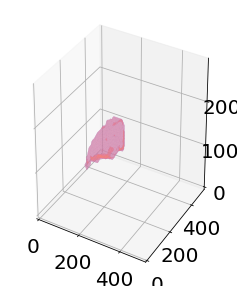

1 339 141 241 97 165 64


In [ ]:
#@title get only one big lesion {vertical-output: true}

lab_areas = np.array(ndimage.sum(target_mask3, lab, np.arange(lab.max()+1)))
mask_small_lab_areas = lab_areas > 5000
one_big_lesion = mask_small_lab_areas[lab.ravel()].reshape(lab.shape)
lab, nr_ = label(one_big_lesion)
plot_3d_2(np.moveaxis(one_big_lesion,2,0), np.moveaxis(one_big_lesion,2,0), .5, detail_speed=8, detail_speed2=8, figsize=(4,5))
y_min_lesion, y_max_lesion, x_min_lesion, x_max_lesion, z_min_lesion, z_max_lesion = get_min_max(one_big_lesion)
print(nr_,y_max_lesion, y_min_lesion, x_max_lesion, x_min_lesion, z_max_lesion, z_min_lesion)

141 339 97 241 64 165 2
140 362 97 265 41 245


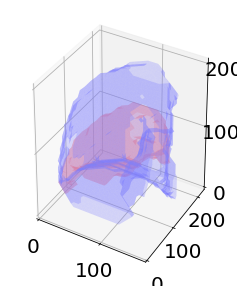

In [ ]:
#@title get lung that contains lesion {vertical-output: true}
for i in np.arange(1,3):
  y_min, y_max, x_min, x_max, z_min, z_max = get_min_max(two_lungs, LABEL=i)
  if y_min_lesion >= y_min and y_max_lesion <= y_max and x_min_lesion >= x_min and x_max_lesion <= x_max and z_min_lesion >= z_min and z_max_lesion <= z_max:
    print(y_min_lesion, y_max_lesion, x_min_lesion, x_max_lesion, z_min_lesion, z_max_lesion, i)
    print(y_min, y_max, x_min, x_max, z_min, z_max)
    coords_lung_inpaint = y_min, y_max, x_min, x_max, z_min, z_max
lung_inpaint = ct_seg_small[coords_lung_inpaint[0]:coords_lung_inpaint[1],coords_lung_inpaint[2]:coords_lung_inpaint[3],coords_lung_inpaint[4]:coords_lung_inpaint[5]]
lung_one_big_lesion = one_big_lesion[coords_lung_inpaint[0]:coords_lung_inpaint[1],coords_lung_inpaint[2]:coords_lung_inpaint[3],coords_lung_inpaint[4]:coords_lung_inpaint[5]]
plot_3d_2(np.moveaxis(lung_inpaint>0,2,0), np.moveaxis(lung_one_big_lesion,2,0), .5, detail_speed=8, detail_speed2=8, figsize=(4,5))

[False  True]
(224, 192, 224) (224, 192, 224) (224, 192, 224)


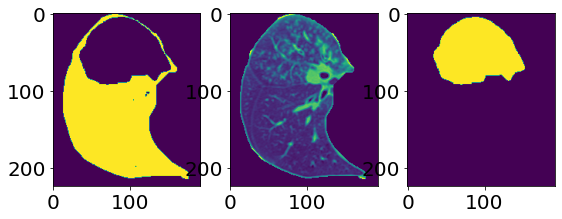

In [ ]:
#@title add zeros outsides the lungs to the mask until multiple of 32 {vertical-output: true}
mask_inpain = ~(lung_one_big_lesion + (lung_inpaint==0))
img = pad_two_size_multiple_32(lung_inpaint)
mask_inpain = pad_two_size_multiple_32(mask_inpain)
lung_one_lesion = pad_two_size_multiple_32(lung_inpaint, lung_one_big_lesion)
print(np.unique(mask_inpain))
print(np.shape(mask_inpain), np.shape(img), np.shape(lung_one_lesion))
fig, ax = plt.subplots(1,3, figsize=(9,6))
ax[0].imshow(mask_inpain[...,100])
ax[1].imshow(img[...,100])
ax[2].imshow(lung_one_lesion[...,100])

(224, 192, 224)
(198, 144, 101)


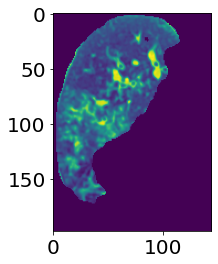

In [ ]:
#@title focus on the lesion {vertical-output: true}
target_img_covid = img * lung_one_lesion
print(np.shape(target_img_covid))
y_min, y_max, x_min, x_max, z_min, z_max =  get_min_max(lung_one_lesion)
target_img_covid = target_img_covid[y_min: y_max, x_min: x_max, z_min: z_max]
print(np.shape(target_img_covid))
plt.imshow(target_img_covid[...,30])

(198, 144, 4)


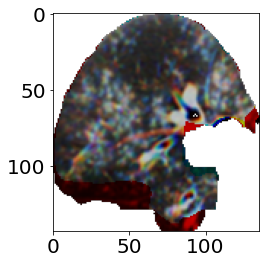

In [ ]:
#@title if RGB-like image was needed {vertical-output: true}
TARGET_SLICE = 50
target_img = target_img_covid[...,TARGET_SLICE:TARGET_SLICE+4] 
print(np.shape(target_img))
target_img[...,-1] = np.sum(target_img, axis=-1) > 0
## crop to only lesion
y_min, y_max, x_min, x_max, z_min, z_max = get_min_max(target_img[...,-1:])
target_img = target_img[y_min: y_max, x_min: x_max, ...].astype('float32')
plt.imshow(target_img);

## Clustering

[-1  0  1  2  3  4  5  6  7  8]


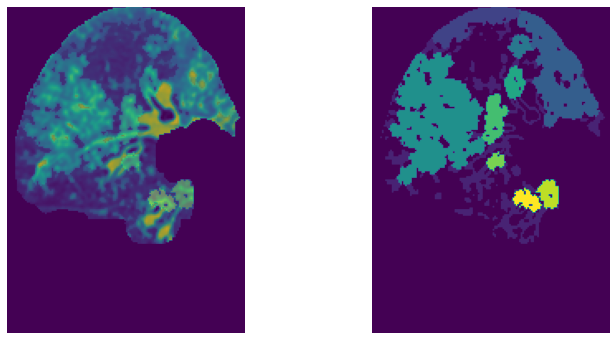

In [ ]:
#@title clustering one slice {vertical-output: true}
SLICE = 50
im = copy(target_img_covid[...,SLICE])
# segment with intensity thresholding
im_r = im.reshape(im.shape[0]*im.shape[1])
for i in range(im_r.shape[0]):
    im_r[i] = np.floor(im_r[i]*5)
im2 = im_r.reshape(im.shape[0],im.shape[1])

# clustering
mask_lesion2 = im2==2
mask_lesion1 = im2==1
mask_lesion = mask_lesion1 + mask_lesion2
small_lesions, labels  = apply_dbscan_to_mask(mask_lesion, skip_low_intensity=2)
print(np.unique(labels))
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].imshow(target_img_covid[...,SLICE], cmap='viridis')
ax[0].imshow(small_lesions, cmap='viridis', alpha=.3)
ax[1].imshow(small_lesions, cmap='viridis')
for axx in ax.ravel(): axx.axis('off')

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


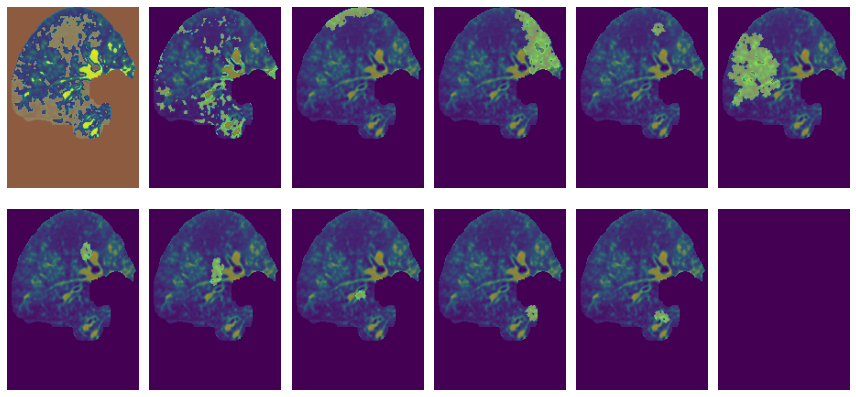

In [ ]:
# plot the regiond identified
cols=6; rows=2
print(np.unique(small_lesions))
just_zeros = np.zeros_like(small_lesions)
fig, ax = plt.subplots(rows,cols, figsize=(12,6))
for i in range(rows*cols):
  if i < len(np.unique(small_lesions)):

    ax.flat[i].imshow(target_img_covid[...,SLICE])
    ax.flat[i].imshow(small_lesions==i, alpha=.4)
  else:
    ax.flat[i].imshow(just_zeros)
for axx in ax.ravel(): axx.axis('off')
fig.tight_layout()

In [ ]:
tgt_small, tgt_coords_small, tgt_masks_small, tgt_big, tgt_coords_big, tgt_masks_big =  select_lesions_match_conditions(small_lesions, target_img_covid, max_size=1000)

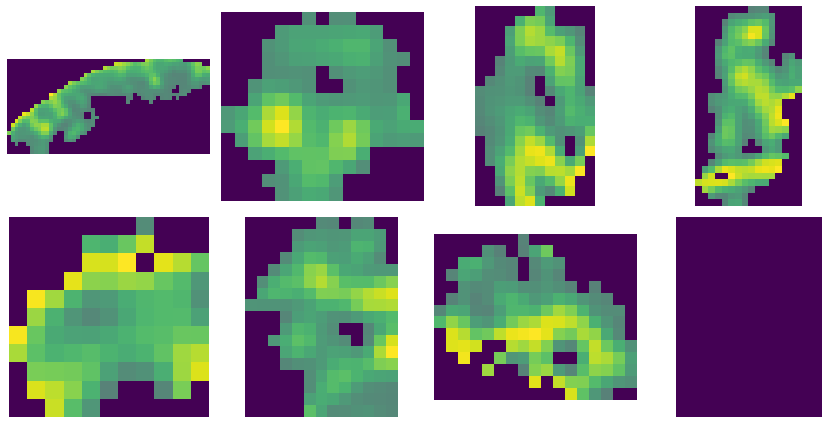

In [ ]:
# plot the lesions
n_rows = 2
n_cols = int(np.ceil(len(tgt_small)/n_rows))
fig, ax = plt.subplots(n_rows, n_cols, figsize=(12,6))
just_zeros = np.zeros_like(small_lesions)
for i in range(n_rows*n_cols):
  if i < len(tgt_small):
    ax.flat[i].imshow(tgt_small[i])
    ax.flat[i].imshow(tgt_masks_small[i], alpha=.2)
  else:
    ax.flat[i].imshow(just_zeros)
for axx in ax.ravel(): axx.axis('off')
fig.tight_layout()

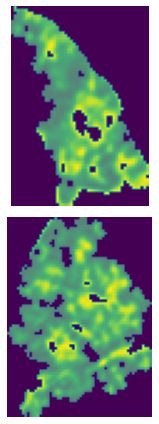

In [ ]:
# plot the big lesions
n_rows = 2
n_cols = int(np.ceil(len(tgt_big)/n_rows))
fig, ax = plt.subplots(n_rows, n_cols, figsize=(12,6))
just_zeros = np.zeros_like(small_lesions)
for i in range(n_rows*n_cols):
  if i < len(tgt_big):
    ax.flat[i].imshow(tgt_big[i])
    ax.flat[i].imshow(tgt_masks_big[i], alpha=.2)
  else:
    ax.flat[i].imshow(just_zeros)
for axx in ax.ravel(): axx.axis('off')
fig.tight_layout()

In [ ]:
targets, seeds = make_list_of_targets_and_seeds(tgt_small)
np.shape(targets[0]), len(targets)

((25, 53, 2), 7)

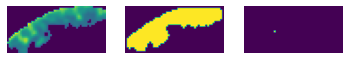

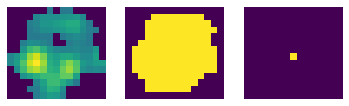

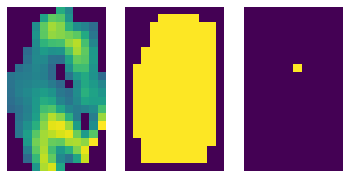

In [ ]:
for idx, (i,j) in enumerate(zip(targets, seeds)):
  if idx == 3: break
  fig, ax = plt.subplots(1,3)
  ax[0].imshow(i[...,0])
  ax[1].imshow(i[...,1])
  ax[2].imshow(j)
  for axx in ax.ravel(): axx.axis('off')

In [ ]:
np.shape(targets[0]), len(targets)

((25, 53, 2), 7)

## big lesions

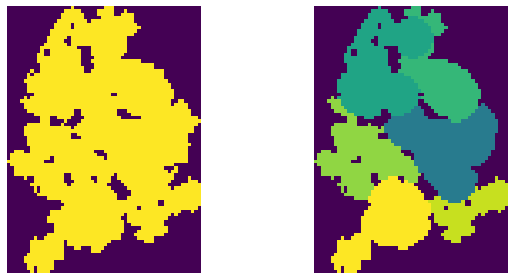

In [ ]:
#@title all functions together {vertical-output: true}
mask_small = tgt_masks_big[1]
# grid search DBSCAN
eps_sel, samp_sel = grid_search_DBSCAN_params(mask_small)
smaller_lesions, labels = apply_dbscan_to_mask(mask_small, eps=eps_sel, min_samples=samp_sel)
# use label to get not clustered areas 
skip_low_intensity = 2
last_idx = np.max(np.unique(labels))+skip_low_intensity
smaller_multi = label_mask_and_add_to_clusters(smaller_lesions, last_idx)
# merge labeled clusters
smaller_merged = merge_labeled_clusters(smaller_multi, DIST=40)
# figure
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].imshow(mask_small)
ax[1].imshow(smaller_merged)
for axx in ax.ravel(): axx.axis('off')
fig.tight_layout()

In [ ]:
tgt_small2, tgt_coords_small2, tgt_masks_small2, tgt_big2, tgt_coords_big2, tgt_masks_big2 =  select_lesions_match_conditions(smaller_merged, target_img_covid, max_size=1000)

In [ ]:
len(tgt_small2), len(tgt_big2)

(6, 0)

In [ ]:
targets, seeds = make_list_of_targets_and_seeds(tgt_small2, targets=targets, seeds=seeds)
len(targets), np.shape(targets[0])

(13, (25, 53, 2))

In [ ]:
# # make the seeds in the gravity center of each lesion
# targets = []
# seeds = []
# for i in tgt_small:
#   target_temp = np.zeros((np.shape(i)[0],np.shape(i)[1],2))
#   target_temp[...,0] = i
#   mask_mini_closed = binary_closing(i>0)
#   target_temp[...,1] = mask_mini_closed
#   targets.append((target_temp).astype('float32'))
#   mask_mini_dt = distance_transform_bf(mask_mini_closed)
#   seed = mask_mini_dt==np.max(mask_mini_dt)
#   if np.sum(seed)>1: 
#     yy, xx = np.where(seed==1)
#     seed = np.zeros_like(mask_mini_dt)
#     seed[yy[0], xx[0]] = .11
#   seeds.append(seed)

In [ ]:
# put all lesions that satisfy conditions in lists (for the lesion, its coords and its mask)
print(np.unique(small_lesions))
target_minis = []
target_minis_coords = []
target_minis_masks = []
for i in np.unique(small_lesions):
  mm = small_lesions==i
  y_min, y_max, x_min, x_max, _, _ = get_min_max(np.expand_dims(mm,-1))
  mask_mini = (small_lesions==i)[y_min:y_max,x_min:x_max]
  target_mini = target_img_covid[y_min:y_max,x_min:x_max,SLICE]
  if i > 1:
    target_minis.append(mask_mini*target_mini)
    target_minis_coords.append((y_min, y_max, x_min, x_max))
    target_minis_masks.append(mask_mini)
  
for axx in ax.ravel(): axx.axis('off')
fig.tight_layout()

# cols=6; rows=2
# fig, ax = plt.subplots(rows,cols, figsize=(12,6))
# for i in range(rows*cols):
#   if i < len(np.unique(mask_lesion3)):
#     ax.flat[i].imshow(target_mini)
#   ax.flat[i].imshow(mask_mini, alpha=.2)
#   else:
#     ax.flat[i].imshow(just_zeros)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
